## Imports and Setup



In [1]:
import os
import zipfile
import tarfile
import json
import xml.etree.ElementTree as ET
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import logging
import random

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set seaborn style for better visualizations
sns.set(style='whitegrid', font_scale=1.2)

logger.info("Libraries imported and logging configured successfully.")

2025-03-21 00:31:04,371 - INFO - Libraries imported and logging configured successfully.


## Define Constants and Mappings



In [2]:
# Define base directory
base_dir = Path('datasets2')

# Selected classes for hazard detection
selected_classes = [
    'pedestrian', 'car', 'bus', 'truck', 'motorcycle', 'bicycle', 'dog',
    'door', 'openedDoor', 'chair', 'table', 'pole'
]

# Class standardization mapping
class_mapping = {
    'People': 'pedestrian',
    'person': 'pedestrian',
    'motorbike': 'motorcycle',
    'bike': 'bicycle',
    'open_door': 'openedDoor'
}

def standardize_class(cls):
    standardized = class_mapping.get(cls, cls)
    logger.debug(f"Standardizing class '{cls}' to '{standardized}'")
    return standardized

logger.info(f"Base directory set to {base_dir}")
logger.info(f"Selected classes: {selected_classes}")
logger.info(f"Class mapping defined with {len(class_mapping)} entries")

2025-03-21 00:31:08,122 - INFO - Base directory set to datasets2
2025-03-21 00:31:08,124 - INFO - Selected classes: ['pedestrian', 'car', 'bus', 'truck', 'motorcycle', 'bicycle', 'dog', 'door', 'openedDoor', 'chair', 'table', 'pole']
2025-03-21 00:31:08,124 - INFO - Class mapping defined with 5 entries


## Extract Datasets



In [3]:
def extract_dataset(file_path, extract_to):
    file_path = base_dir / file_path
    if not file_path.exists():
        logger.error(f"Dataset file {file_path} not found!")
        return False
    if not extract_to.exists():
        logger.info(f"Extracting {file_path} to {extract_to}")
        try:
            if file_path.suffix == '.zip':
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_to)
            elif file_path.suffix == '.tar':
                with tarfile.open(file_path, 'r') as tar_ref:
                    tar_ref.extractall(extract_to)
            else:
                logger.error(f"Unsupported file type: {file_path.suffix}")
                return False
            logger.info(f"Successfully extracted to {extract_to}")
        except Exception as e:
            logger.error(f"Extraction failed for {file_path}: {e}")
            return False
    else:
        logger.info(f"{extract_to} already exists, skipping extraction.")
    return True

# Extract all datasets
success_ninja = extract_dataset('ninja.tar', base_dir / 'ninja')
success_wotr = extract_dataset('WOTR.zip', base_dir / 'WOTR')
success_risk = extract_dataset('risk-detection.zip', base_dir / 'risk-detection-1')

print(f"Extraction status - ninja: {success_ninja}, WOTR: {success_wotr}, risk-detection: {success_risk}")

2025-03-21 00:31:12,119 - INFO - datasets2/ninja already exists, skipping extraction.
2025-03-21 00:31:12,121 - INFO - datasets2/WOTR already exists, skipping extraction.
2025-03-21 00:31:12,122 - INFO - datasets2/risk-detection-1 already exists, skipping extraction.


Extraction status - ninja: True, WOTR: True, risk-detection: True


## Parse Ninja Annotations



In [4]:
def find_image_file(img_folder, base_name):
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = img_folder / (base_name + ext)
        if candidate.exists():
            logger.debug(f"Found image: {candidate}")
            return candidate
    logger.warning(f"No image found for base name {base_name} in {img_folder}")
    return None

def parse_ninja_annotations(folder):
    class_counts = defaultdict(int)
    image_class_map = {}
    splits = ['train', 'valid', 'test']
    for split in splits:
        ann_folder = folder / split / 'ann'
        img_folder = folder / split / 'img'
        if not ann_folder.exists() or not img_folder.exists():
            logger.warning(f"Missing 'ann' or 'img' folder in {split} split")
            continue
        ann_files = list(ann_folder.glob('*.json'))
        logger.info(f"Found {len(ann_files)} annotation files in {split}")
        for ann_file in tqdm(ann_files, desc=f"Parsing ninja {split}"):
            base_name = ann_file.stem.split('.')[0]  # e.g., '109' from '109.png.json'
            img_file = find_image_file(img_folder, base_name)
            if not img_file:
                continue
            img_key = f"{split}/{img_file.name}"
            try:
                with open(ann_file, 'r') as f:
                    data = json.load(f)
                classes_in_image = set()
                for obj in data.get('objects', []):
                    cls = standardize_class(obj.get('classTitle', 'unknown'))
                    class_counts[cls] += 1
                    classes_in_image.add(cls)
                image_class_map[img_key] = list(classes_in_image)
            except Exception as e:
                logger.error(f"Error parsing {ann_file}: {e}")
    return class_counts, image_class_map

# Parse ninja dataset
ninja_folder = base_dir / 'ninja'
ninja_class_counts, ninja_image_class_map = parse_ninja_annotations(ninja_folder)
print(f"ninja: {len(ninja_image_class_map)} images, {len(ninja_class_counts)} unique classes")
logger.info(f"Parsed ninja dataset: {sum(ninja_class_counts.values())} total annotations")

2025-03-21 00:31:15,872 - INFO - Found 1012 annotation files in train
Parsing ninja train:   0%|          | 0/1012 [00:00<?, ?it/s]2025-03-21 00:31:15,882 - WARNING - No image found for base name DOR_S3_79 in datasets2/ninja/train/img
2025-03-21 00:31:15,892 - WARNING - No image found for base name DOR_S3_73 in datasets2/ninja/train/img
2025-03-21 00:31:15,895 - WARNING - No image found for base name DOR_S3_22 in datasets2/ninja/train/img
2025-03-21 00:31:15,897 - WARNING - No image found for base name DOR_S3_18 in datasets2/ninja/train/img
2025-03-21 00:31:15,898 - WARNING - No image found for base name DOR_S3_74 in datasets2/ninja/train/img
2025-03-21 00:31:15,899 - WARNING - No image found for base name DOR_S3_19 in datasets2/ninja/train/img
2025-03-21 00:31:15,901 - WARNING - No image found for base name DOR_S3_69 in datasets2/ninja/train/img
2025-03-21 00:31:15,911 - WARNING - No image found for base name DOR_S3_84 in datasets2/ninja/train/img
2025-03-21 00:31:15,912 - WARNING - N

ninja: 1321 images, 10 unique classes


## Parse WOTR Annotations



In [5]:
def parse_wotr_annotations(folder):
    class_counts = defaultdict(int)
    image_class_map = {}
    ann_folder = folder / 'WOTR' / 'Annotations'
    img_folder = folder / 'WOTR' / 'JPEGImages'
    # Handle alternate folder structure
    if not ann_folder.exists():
        ann_folder = folder / 'Annotations'
        img_folder = folder / 'JPEGImages'
    if not ann_folder.exists() or not img_folder.exists():
        logger.error(f"Cannot find 'Annotations' or 'JPEGImages' in {folder}")
        return class_counts, image_class_map
    ann_files = list(ann_folder.glob('*.xml'))
    logger.info(f"Found {len(ann_files)} XML annotation files in WOTR")
    for ann_file in tqdm(ann_files, desc="Parsing WOTR"):
        try:
            # Use the XML filename (without extension) to find the image
            base_name = ann_file.stem  # e.g., '10000001'
            img_path = img_folder / f"{base_name}.jpg"  # Assuming .jpg extension
            if not img_path.exists():
                logger.warning(f"No image found for {ann_file} at {img_path}")
                continue
            img_key = img_path.name  # e.g., '10000001.jpg'
            # Parse the XML
            tree = ET.parse(ann_file)
            root = tree.getroot()
            classes_in_image = set()
            for obj in root.findall('object'):
                cls = standardize_class(obj.find('name').text)
                if cls in selected_classes:  # Only include selected classes
                    class_counts[cls] += 1
                    classes_in_image.add(cls)
            if classes_in_image:  # Only add to map if there are relevant classes
                image_class_map[img_key] = list(classes_in_image)
        except Exception as e:
            logger.error(f"Error parsing {ann_file}: {e}")
    return class_counts, image_class_map

# Parse WOTR dataset
wotr_folder = base_dir / 'WOTR'
wotr_class_counts, wotr_image_class_map = parse_wotr_annotations(wotr_folder)
print(f"WOTR: {len(wotr_image_class_map)} images, {len(wotr_class_counts)} unique classes")
logger.info(f"Parsed WOTR dataset: {sum(wotr_class_counts.values())} total annotations")

2025-03-21 00:31:20,533 - INFO - Found 13928 XML annotation files in WOTR
Parsing WOTR: 100%|██████████| 13928/13928 [00:02<00:00, 5606.16it/s]
2025-03-21 00:31:23,021 - INFO - Parsed WOTR dataset: 118475 total annotations


WOTR: 11916 images, 8 unique classes


## Parse Risk-Detection Annotations



In [6]:
def parse_risk_detection_annotations(folder):
    # Load class names from data.yaml
    yaml_path = folder / 'data.yaml'
    if not yaml_path.exists():
        logger.error(f"data.yaml not found in {folder}")
        return defaultdict(int), {}
    with open(yaml_path, 'r') as f:
        data_yaml = yaml.safe_load(f)
    class_names = data_yaml.get('names', [])
    logger.info(f"Loaded {len(class_names)} class names from data.yaml")
    
    class_counts = defaultdict(int)
    image_class_map = {}
    splits = ['train', 'valid', 'test']
    for split in splits:
        label_folder = folder / split / 'labels'
        img_folder = folder / split / 'images'
        if not label_folder.exists() or not img_folder.exists():
            logger.warning(f"Missing 'labels' or 'images' in {split} split")
            continue
        label_files = list(label_folder.glob('*.txt'))
        logger.info(f"Found {len(label_files)} label files in {split}")
        for label_file in tqdm(label_files, desc=f"Parsing risk-detection {split}"):
            base_name = label_file.stem
            img_file = find_image_file(img_folder, base_name)
            if not img_file:
                continue
            img_key = f"{split}/{img_file.name}"
            try:
                with open(label_file, 'r') as f:
                    lines = f.readlines()
                classes_in_image = set()
                for line in lines:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    idx = int(parts[0])
                    cls = standardize_class(class_names[idx]) if idx < len(class_names) else f"unknown_{idx}"
                    class_counts[cls] += 1
                    classes_in_image.add(cls)
                image_class_map[img_key] = list(classes_in_image)
            except Exception as e:
                logger.error(f"Error parsing {label_file}: {e}")
    return class_counts, image_class_map

# Parse risk-detection dataset
risk_folder = base_dir / 'risk-detection-1'
risk_class_counts, risk_image_class_map = parse_risk_detection_annotations(risk_folder)
print(f"risk-detection: {len(risk_image_class_map)} images, {len(risk_class_counts)} unique classes")
logger.info(f"Parsed risk-detection dataset: {sum(risk_class_counts.values())} total annotations")

2025-03-21 00:31:25,728 - INFO - Loaded 16 class names from data.yaml
2025-03-21 00:31:25,877 - INFO - Found 52670 label files in train
Parsing risk-detection train: 100%|██████████| 52670/52670 [00:03<00:00, 15705.18it/s]
2025-03-21 00:31:29,253 - INFO - Found 2022 label files in valid
Parsing risk-detection valid: 100%|██████████| 2022/2022 [00:00<00:00, 12173.34it/s]
2025-03-21 00:31:29,427 - INFO - Found 1114 label files in test
Parsing risk-detection test: 100%|██████████| 1114/1114 [00:00<00:00, 13260.95it/s]
2025-03-21 00:31:29,514 - INFO - Parsed risk-detection dataset: 218811 total annotations


risk-detection: 55806 images, 16 unique classes


## Analyze Image Properties



In [7]:
def analyze_image_properties(image_class_map, dataset_name, sample_size=100):
    """
    Analyze properties of a random sample of images containing selected classes.
    
    Args:
        image_class_map (dict): Mapping of image keys to their classes.
        dataset_name (str): Name of the dataset ('ninja', 'WOTR', 'risk-detection-1').
        sample_size (int): Number of images to sample (default: 100).
    
    Returns:
        dict: Properties including sizes, color, blurriness, brightness, and object counts.
    """
    properties = {
        'sizes': [], 'is_colored': [], 'blurriness': [],
        'brightness': [], 'objects_per_image': []
    }
    
    # Filter images that contain at least one selected class
    relevant_images = [
        img for img, classes in image_class_map.items()
        if any(cls in selected_classes for cls in classes)
    ]
    logger.info(f"Found {len(relevant_images)} images with selected classes in {dataset_name}")
    
    if not relevant_images:
        logger.warning(f"No images with selected classes found in {dataset_name}")
        return properties
    
    # Sample 100 images
    if len(relevant_images) > sample_size:
        keys = random.sample(relevant_images, sample_size)
        logger.info(f"Sampling {sample_size} out of {len(relevant_images)} relevant images for {dataset_name}")
    else:
        keys = relevant_images
        logger.info(f"Using all {len(keys)} relevant images for {dataset_name}")
    
    for img_key in tqdm(keys, desc=f"Analyzing {dataset_name} images"):
        try:
            
            if dataset_name == 'ninja':
                split, img_name = img_key.split('/')
                img_path = base_dir / 'ninja' / split / 'img' / img_name
            elif dataset_name == 'WOTR':
                img_path = base_dir / 'WOTR' / 'WOTR' /'JPEGImages' / img_key
            elif dataset_name == 'risk-detection-1':
                split, img_name = img_key.split('/')
                img_path = base_dir / 'risk-detection-1' / split / 'images' / img_name
            else:
                logger.error(f"Unknown dataset: {dataset_name}")
                continue
            
            if not img_path.exists():
                logger.warning(f"Image {img_path} not found")
                continue
            
            # Analyze size and color
            with Image.open(img_path) as img:
                properties['sizes'].append(img.size)
                properties['is_colored'].append(img.mode == 'RGB')
            
            # Analyze blurriness (Laplacian variance)
            img_cv = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img_cv is not None:
                variance = cv2.Laplacian(img_cv, cv2.CV_64F).var()
                properties['blurriness'].append(variance)
            else:
                properties['blurriness'].append(0)
                logger.warning(f"Failed to load {img_path} for blurriness analysis")
            
            # Analyze brightness
            img_rgb = cv2.imread(str(img_path))
            if img_rgb is not None:
                brightness = np.mean(img_rgb)
                properties['brightness'].append(brightness)
            else:
                properties['brightness'].append(0)
                logger.warning(f"Failed to load {img_path} for brightness analysis")
            
            # Count objects
            properties['objects_per_image'].append(len(image_class_map[img_key]))
        
        except Exception as e:
            logger.error(f"Error analyzing {img_path}: {e}")
    
    logger.info(f"Completed property analysis for {dataset_name} with {len(properties['sizes'])} images")
    return properties


# Analyze properties for each dataset
ninja_properties = analyze_image_properties(ninja_image_class_map, 'ninja')
wotr_properties = analyze_image_properties(wotr_image_class_map, 'WOTR')
risk_properties = analyze_image_properties(risk_image_class_map, 'risk-detection-1')

2025-03-21 00:31:30,374 - INFO - Found 643 images with selected classes in ninja
2025-03-21 00:31:30,375 - INFO - Sampling 100 out of 643 relevant images for ninja
Analyzing ninja images: 100%|██████████| 100/100 [00:01<00:00, 50.81it/s]
2025-03-21 00:31:32,345 - INFO - Completed property analysis for ninja with 100 images
2025-03-21 00:31:32,353 - INFO - Found 11916 images with selected classes in WOTR
2025-03-21 00:31:32,353 - INFO - Sampling 100 out of 11916 relevant images for WOTR
Analyzing WOTR images: 100%|██████████| 100/100 [00:00<00:00, 102.80it/s]
2025-03-21 00:31:33,328 - INFO - Completed property analysis for WOTR with 100 images
2025-03-21 00:31:33,364 - INFO - Found 6507 images with selected classes in risk-detection-1
2025-03-21 00:31:33,364 - INFO - Sampling 100 out of 6507 relevant images for risk-detection-1
Analyzing risk-detection-1 images: 100%|██████████| 100/100 [00:00<00:00, 140.96it/s]
2025-03-21 00:31:34,077 - INFO - Completed property analysis for risk-detec

## Generate Visualizations



In [8]:
def plot_class_distribution(counts, dataset_name, selected_only=False):
    if selected_only:
        data = {k: v for k, v in counts.items() if k in selected_classes}
        title = f"Selected Class Distribution - {dataset_name}"
        filename = f"{dataset_name}_selected_class_distribution.png"
    else:
        data = counts
        title = f"Full Class Distribution - {dataset_name}"
        filename = f"{dataset_name}_full_class_distribution.png"
    
    df = pd.DataFrame({'Class': list(data.keys()), 'Count': list(data.values())}).sort_values('Count', ascending=False)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=df, x='Class', y='Count', palette='Set2')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Instance Count', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    logger.info(f"Saved plot: {filename}")

def plot_image_properties(properties, dataset_name):
    """
    Generate plots for image properties.
    
    Args:
        properties (dict): Dictionary containing image properties.
        dataset_name (str): Name of the dataset.
    """
    if not properties['sizes']:
        logger.warning(f"No image properties to plot for {dataset_name}")
        return
    
    # Image Size Distribution
    widths, heights = zip(*properties['sizes'])
    plt.figure(figsize=(10, 6))
    sns.histplot(widths, bins=30, color='blue', label='Width', kde=True, alpha=0.6)
    sns.histplot(heights, bins=30, color='red', label='Height', kde=True, alpha=0.6)
    plt.title(f"Image Size Distribution - {dataset_name}", fontsize=16)
    plt.xlabel('Pixels', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.savefig(f"{dataset_name}_size_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Color Distribution
    color_counts = {
        'Colored': sum(properties['is_colored']),
        'Grayscale': len(properties['is_colored']) - sum(properties['is_colored'])
    }
    df = pd.DataFrame({'Category': list(color_counts.keys()), 'Count': list(color_counts.values())})
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=df, x='Category', y='Count', palette='viridis')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.title(f"Color Distribution - {dataset_name}", fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(f"{dataset_name}_color_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Blurriness Distribution
    blurry = sum(1 for b in properties['blurriness'] if b < 100)
    df = pd.DataFrame({
        'Category': ['Blurry (<100)', 'Clear (≥100)'],
        'Count': [blurry, len(properties['blurriness']) - blurry]
    })
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=df, x='Category', y='Count', palette='magma')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.title(f"Blurriness Distribution - {dataset_name}", fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(f"{dataset_name}_blurriness_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Lighting Distribution
    night = sum(1 for b in properties['brightness'] if b < 100)
    df = pd.DataFrame({
        'Category': ['Night (<100)', 'Day (≥100)'],
        'Count': [night, len(properties['brightness']) - night]
    })
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=df, x='Category', y='Count', palette='coolwarm')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    plt.title(f"Lighting Distribution - {dataset_name}", fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.savefig(f"{dataset_name}_lighting_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Objects per Image
    plt.figure(figsize=(10, 6))
    sns.histplot(properties['objects_per_image'], bins=20, color='purple', kde=True)
    plt.title(f"Objects per Image - {dataset_name}", fontsize=16)
    plt.xlabel('Number of Objects', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.savefig(f"{dataset_name}_objects_per_image.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    logger.info(f"Saved all property plots for {dataset_name}")

# Generate visualizations
for dataset, class_counts, properties in [
    ('ninja', ninja_class_counts, ninja_properties),
    ('WOTR', wotr_class_counts, wotr_properties),
    ('risk-detection-1', risk_class_counts, risk_properties)
]:
    logger.info(f"Generating visualizations for {dataset}")
    #plot_class_distribution(class_counts, dataset)
    #plot_class_distribution(class_counts, dataset, selected_only=True)
    #plot_image_properties(properties, dataset)

2025-03-21 00:31:45,463 - INFO - Generating visualizations for ninja
2025-03-21 00:31:45,464 - INFO - Generating visualizations for WOTR
2025-03-21 00:31:45,464 - INFO - Generating visualizations for risk-detection-1


## Combine Class Distributions and Generate Final Plot



/tmp/ipykernel_101417/639102057.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Class', y='Count', palette='Set3')


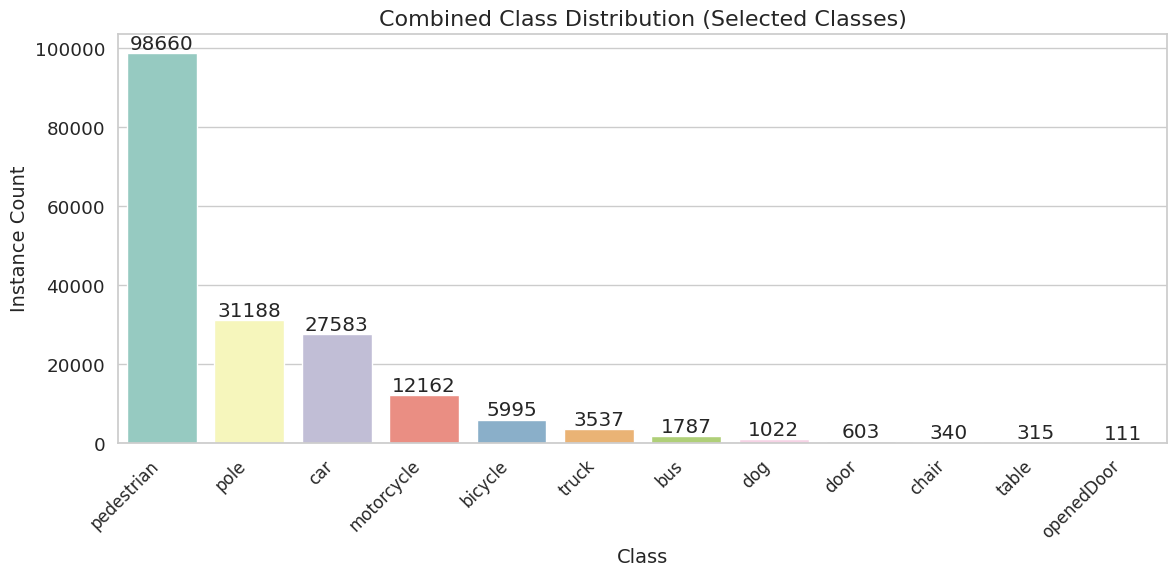

2025-03-21 00:33:36,044 - INFO - Analysis complete. All visualizations saved.



Combined Selected Classes: {'door': 603, 'table': 315, 'openedDoor': 111, 'chair': 340, 'pole': 31188, 'bicycle': 5995, 'truck': 3537, 'car': 27583, 'pedestrian': 98660, 'motorcycle': 12162, 'dog': 1022, 'bus': 1787}


In [15]:
# Combine class counts for selected classes
combined_counts = defaultdict(int)
for class_counts in [ninja_class_counts, wotr_class_counts, risk_class_counts]:
    for cls, count in class_counts.items():
        if cls in selected_classes:
            combined_counts[cls] += count

# Plot combined class distribution
df = pd.DataFrame({'Class': list(combined_counts.keys()), 'Count': list(combined_counts.values())}).sort_values('Count', ascending=False)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Class', y='Count', palette='Set3')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.title("Combined Class Distribution (Selected Classes)", fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Instance Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.savefig("combined_class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nCombined Selected Classes:", dict(combined_counts))
logger.info("Analysis complete. All visualizations saved.")